In [19]:
import pandas as pd
import math
import matplotlib.pyplot as plt
from glob import glob

In [21]:
for path in glob("tests/*.csv"):
    pd.read_csv(path).to_csv(f"{path}.gz", index=False)

In [2]:
minhash = pd.read_csv(
    "tests/test_minhash_jaccard.csv",
)

minhash["mse"] = (minhash["approximation"] - minhash["ground_truth"])**2
minhash = minhash.groupby(["elements", "permutations", "word", "memory"]).agg(["mean", "std"]).reset_index()
minhash

elements permutations word  memory approximation           ground_truth  \
                                                mean       std         mean   
0         10            2  u16      32      0.511500  0.366404     0.490993   
1         10            2  u32      64      0.490500  0.352539     0.490993   
2         10            2  u64     128      0.520500  0.368735     0.490993   
3         10            2   u8      16      0.479500  0.354902     0.490993   
4         10            4  u16      64      0.500250  0.258126     0.490993   
..       ...          ...  ...     ...           ...       ...          ...   
255   100000         4096   u8   32768      1.000000  0.000000     0.462104   
256   100000         8192  u16  131072      0.506684  0.470747     0.462104   
257   100000         8192  u32  262144      0.461612  0.005486     0.462104   
258   100000         8192  u64  524288      0.462007  0.005775     0.462104   
259   100000         8192   u8   65536      1.000000  0.000000     0.462104   

                      time                     mse            
          std         mean           std      mean       std  
0    0.146989        0.002      0.044699  0.112093  0.126124  
1    0.146989        0.005      0.070569  0.098337  0.111724  
2    0.146989        0.000      0.000000  0.114860  0.126133  
3    0.146989        0.011      0.113542  0.101980  0.116750  
4    0.146989        0.001      0.031623  0.045583  0.057082  
..        ...          ...           ...       ...       ...  
255  0.001422  1870725.511   5061.268699  0.289334  0.001530  
256  0.001422  3218707.338  13669.780046  0.223432  0.075883  
257  0.001422  3583093.518   6544.904256  0.000029  0.000040  
258  0.001422  3586078.813   6859.657741  0.000032  0.000043  
259  0.001422  3740117.584   9783.303488  0.289334  0.001530  

[260 rows x 12 columns]

In [3]:
hll = pd.read_csv(
    "tests/test_hll_jaccard.csv",
)

hll["mse"] = (hll["approximation"] - hll["ground_truth"])**2
hll = hll.groupby(["elements", "bits", "memory",]).agg(["mean", "std"]).reset_index()
hll.sort_values("memory")

elements bits  memory precision           approximation            \
                               mean       std          mean       std   
0         10    1      32       4.5  0.500125      0.594538  0.244203   
77       100    1      32       4.5  0.500125      0.883047  0.105771   
89       100    2      32       4.0  0.000000      0.718053  0.124700   
154     1000    1      32       4.5  0.500125      1.000000  0.000000   
166     1000    2      32       4.0  0.000000      1.000000  0.000000   
..       ...  ...     ...       ...       ...           ...       ...   
230     1000    6  393240      16.0  0.000000      0.461822  0.014508   
76        10    6  393240      16.0  0.000000      0.490969  0.146995   
307    10000    6  393240      16.0  0.000000      0.460880  0.005002   
153      100    6  393240      16.0  0.000000      0.464666  0.043984   
384   100000    6  393240      16.0  0.000000      0.462996  0.002484   

    ground_truth                 time                      mse                
            mean       std       mean        std          mean           std  
0       0.490993  0.146952     0.0135   0.127773  6.321965e-02  1.226184e-01  
77      0.464924  0.043956     1.0185   0.145493  1.865127e-01  8.808748e-02  
89      0.464924  0.043967     1.9660   0.211870  7.809382e-02  5.945661e-02  
154     0.463022  0.014382    12.5815   0.735274  2.885516e-01  1.545888e-02  
166     0.463022  0.014386    14.4170   0.824494  2.885516e-01  1.546275e-02  
..           ...       ...        ...        ...           ...           ...  
230     0.463022  0.014386    98.7110   2.726704  3.073115e-06  3.514434e-06  
76      0.490993  0.146989    79.6580   2.590318  6.200221e-10  2.915720e-10  
307     0.462060  0.004723   272.3190   2.993025  4.480234e-06  5.940619e-06  
153     0.464924  0.043967    81.6510   2.668393  6.694367e-08  9.430911e-09  
384     0.462104  0.001422  2232.6430  23.276197  4.965282e-06  7.367944e-06  

[385 rows x 13 columns]

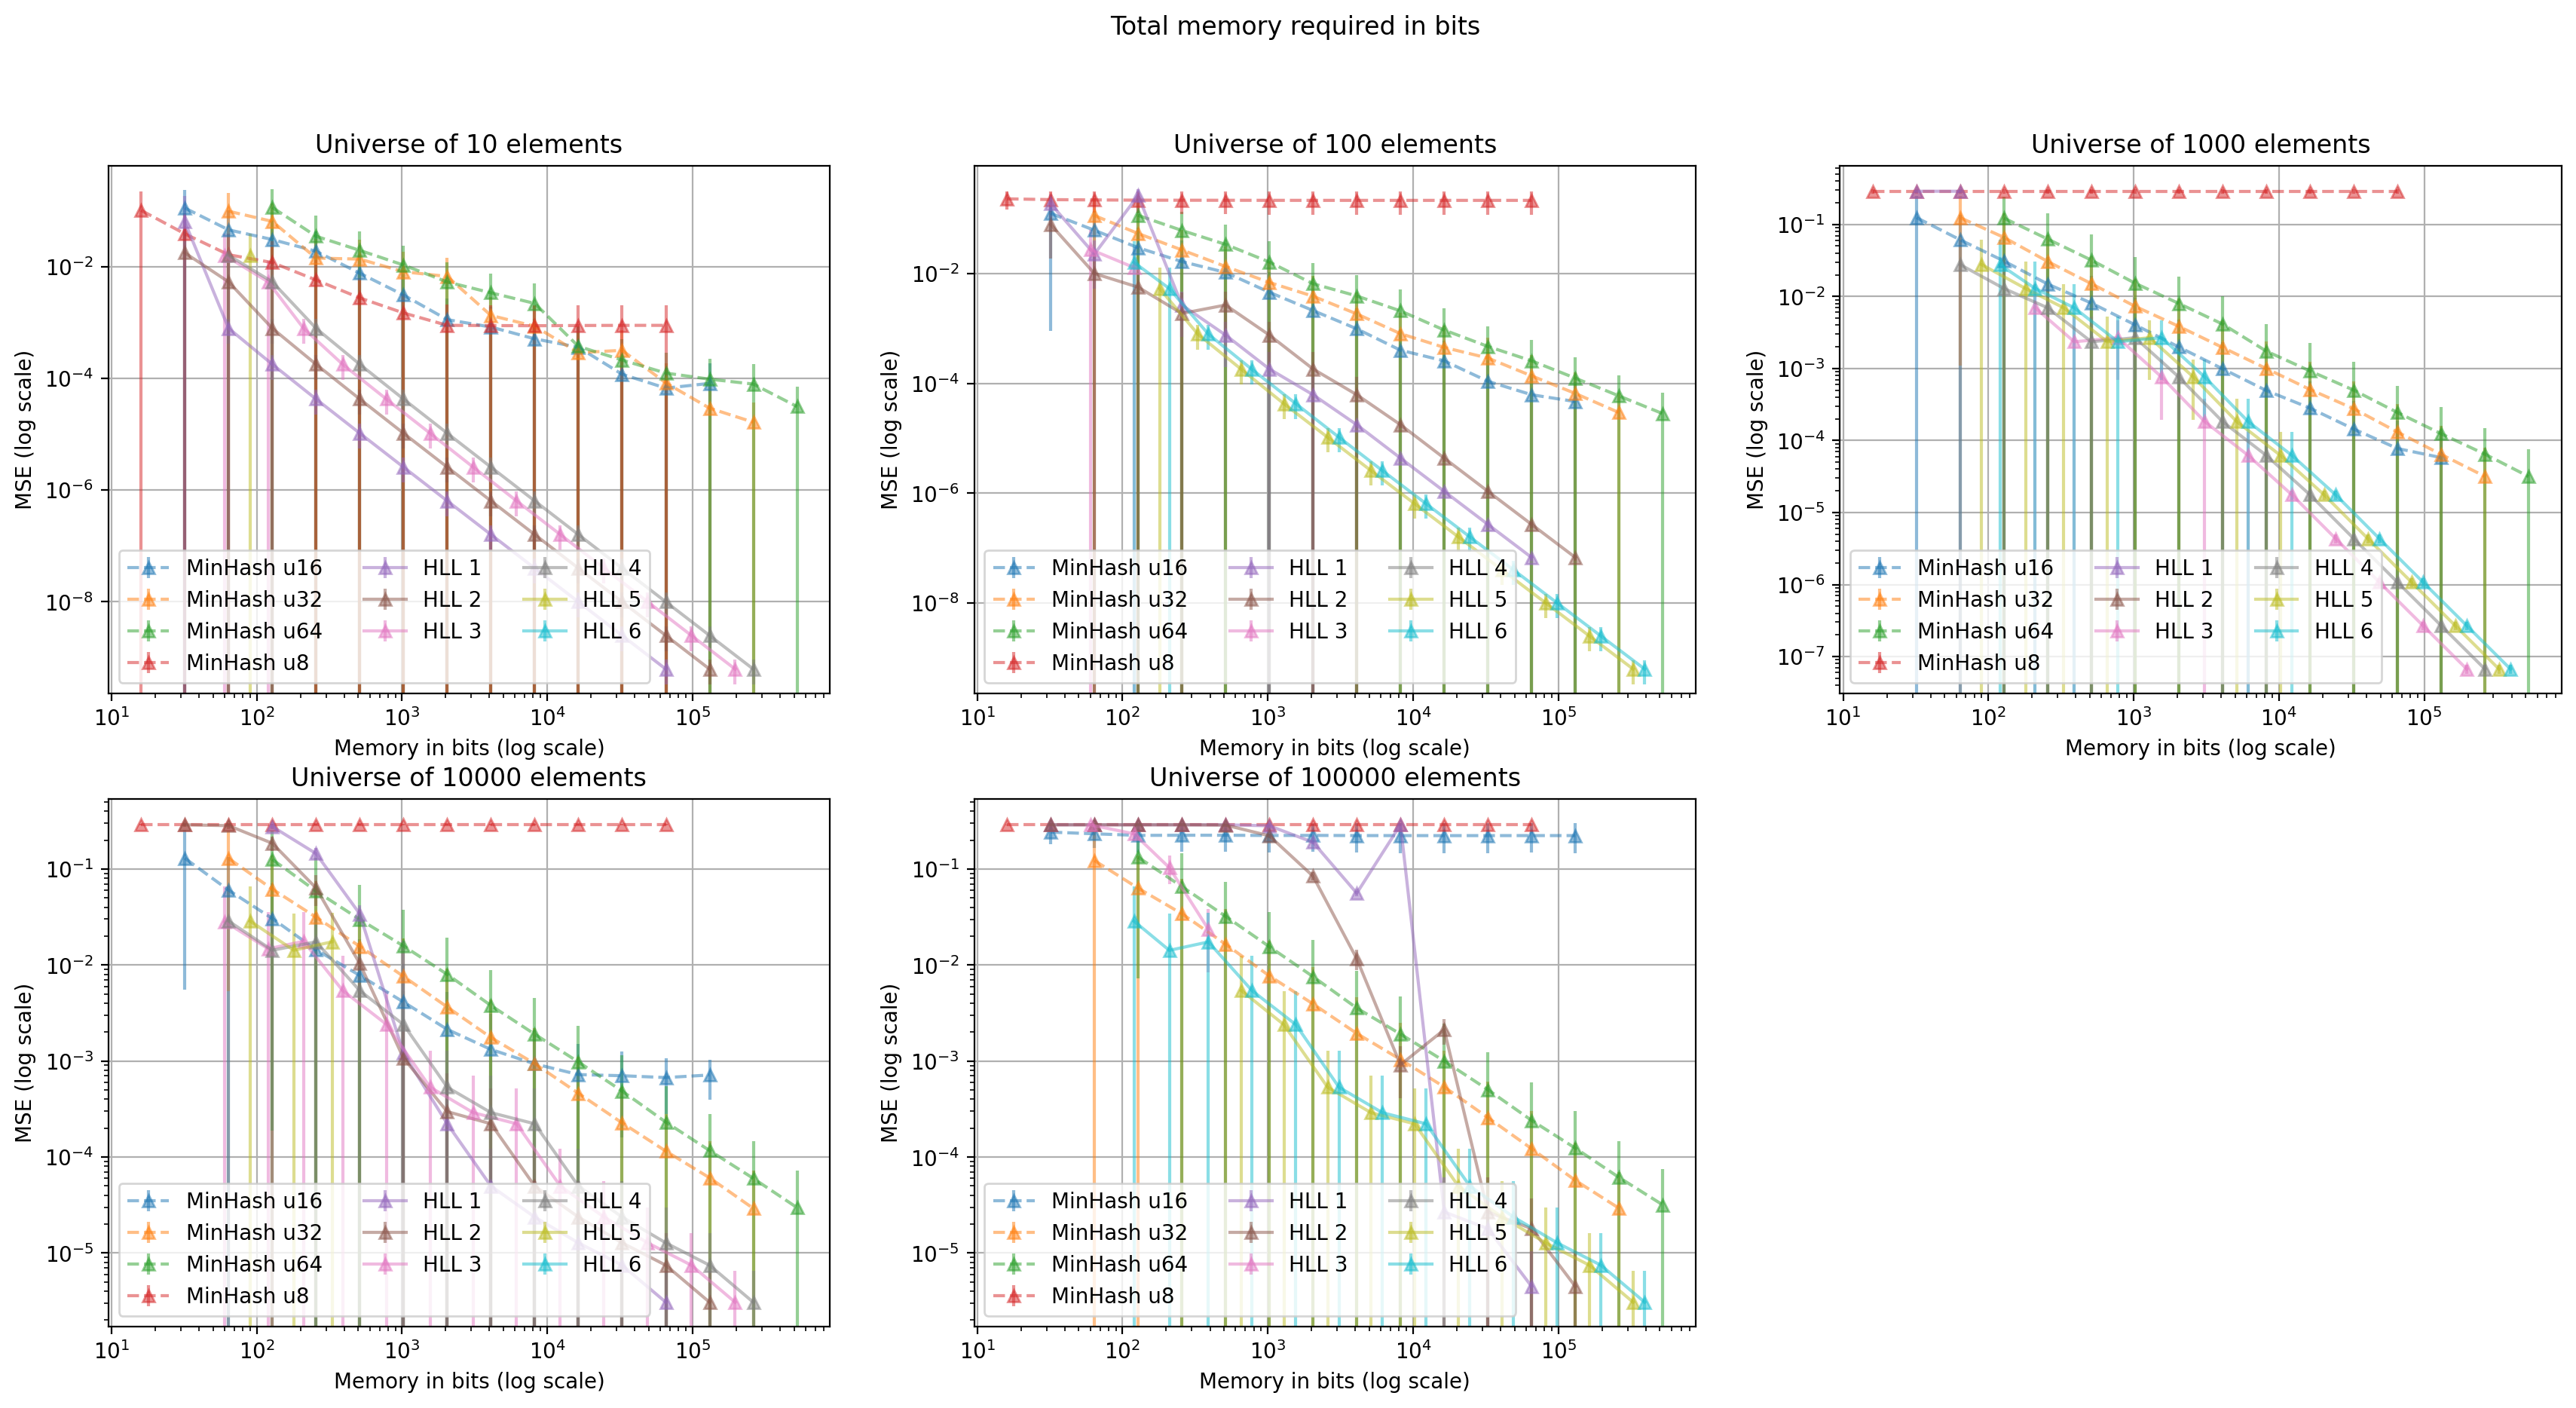

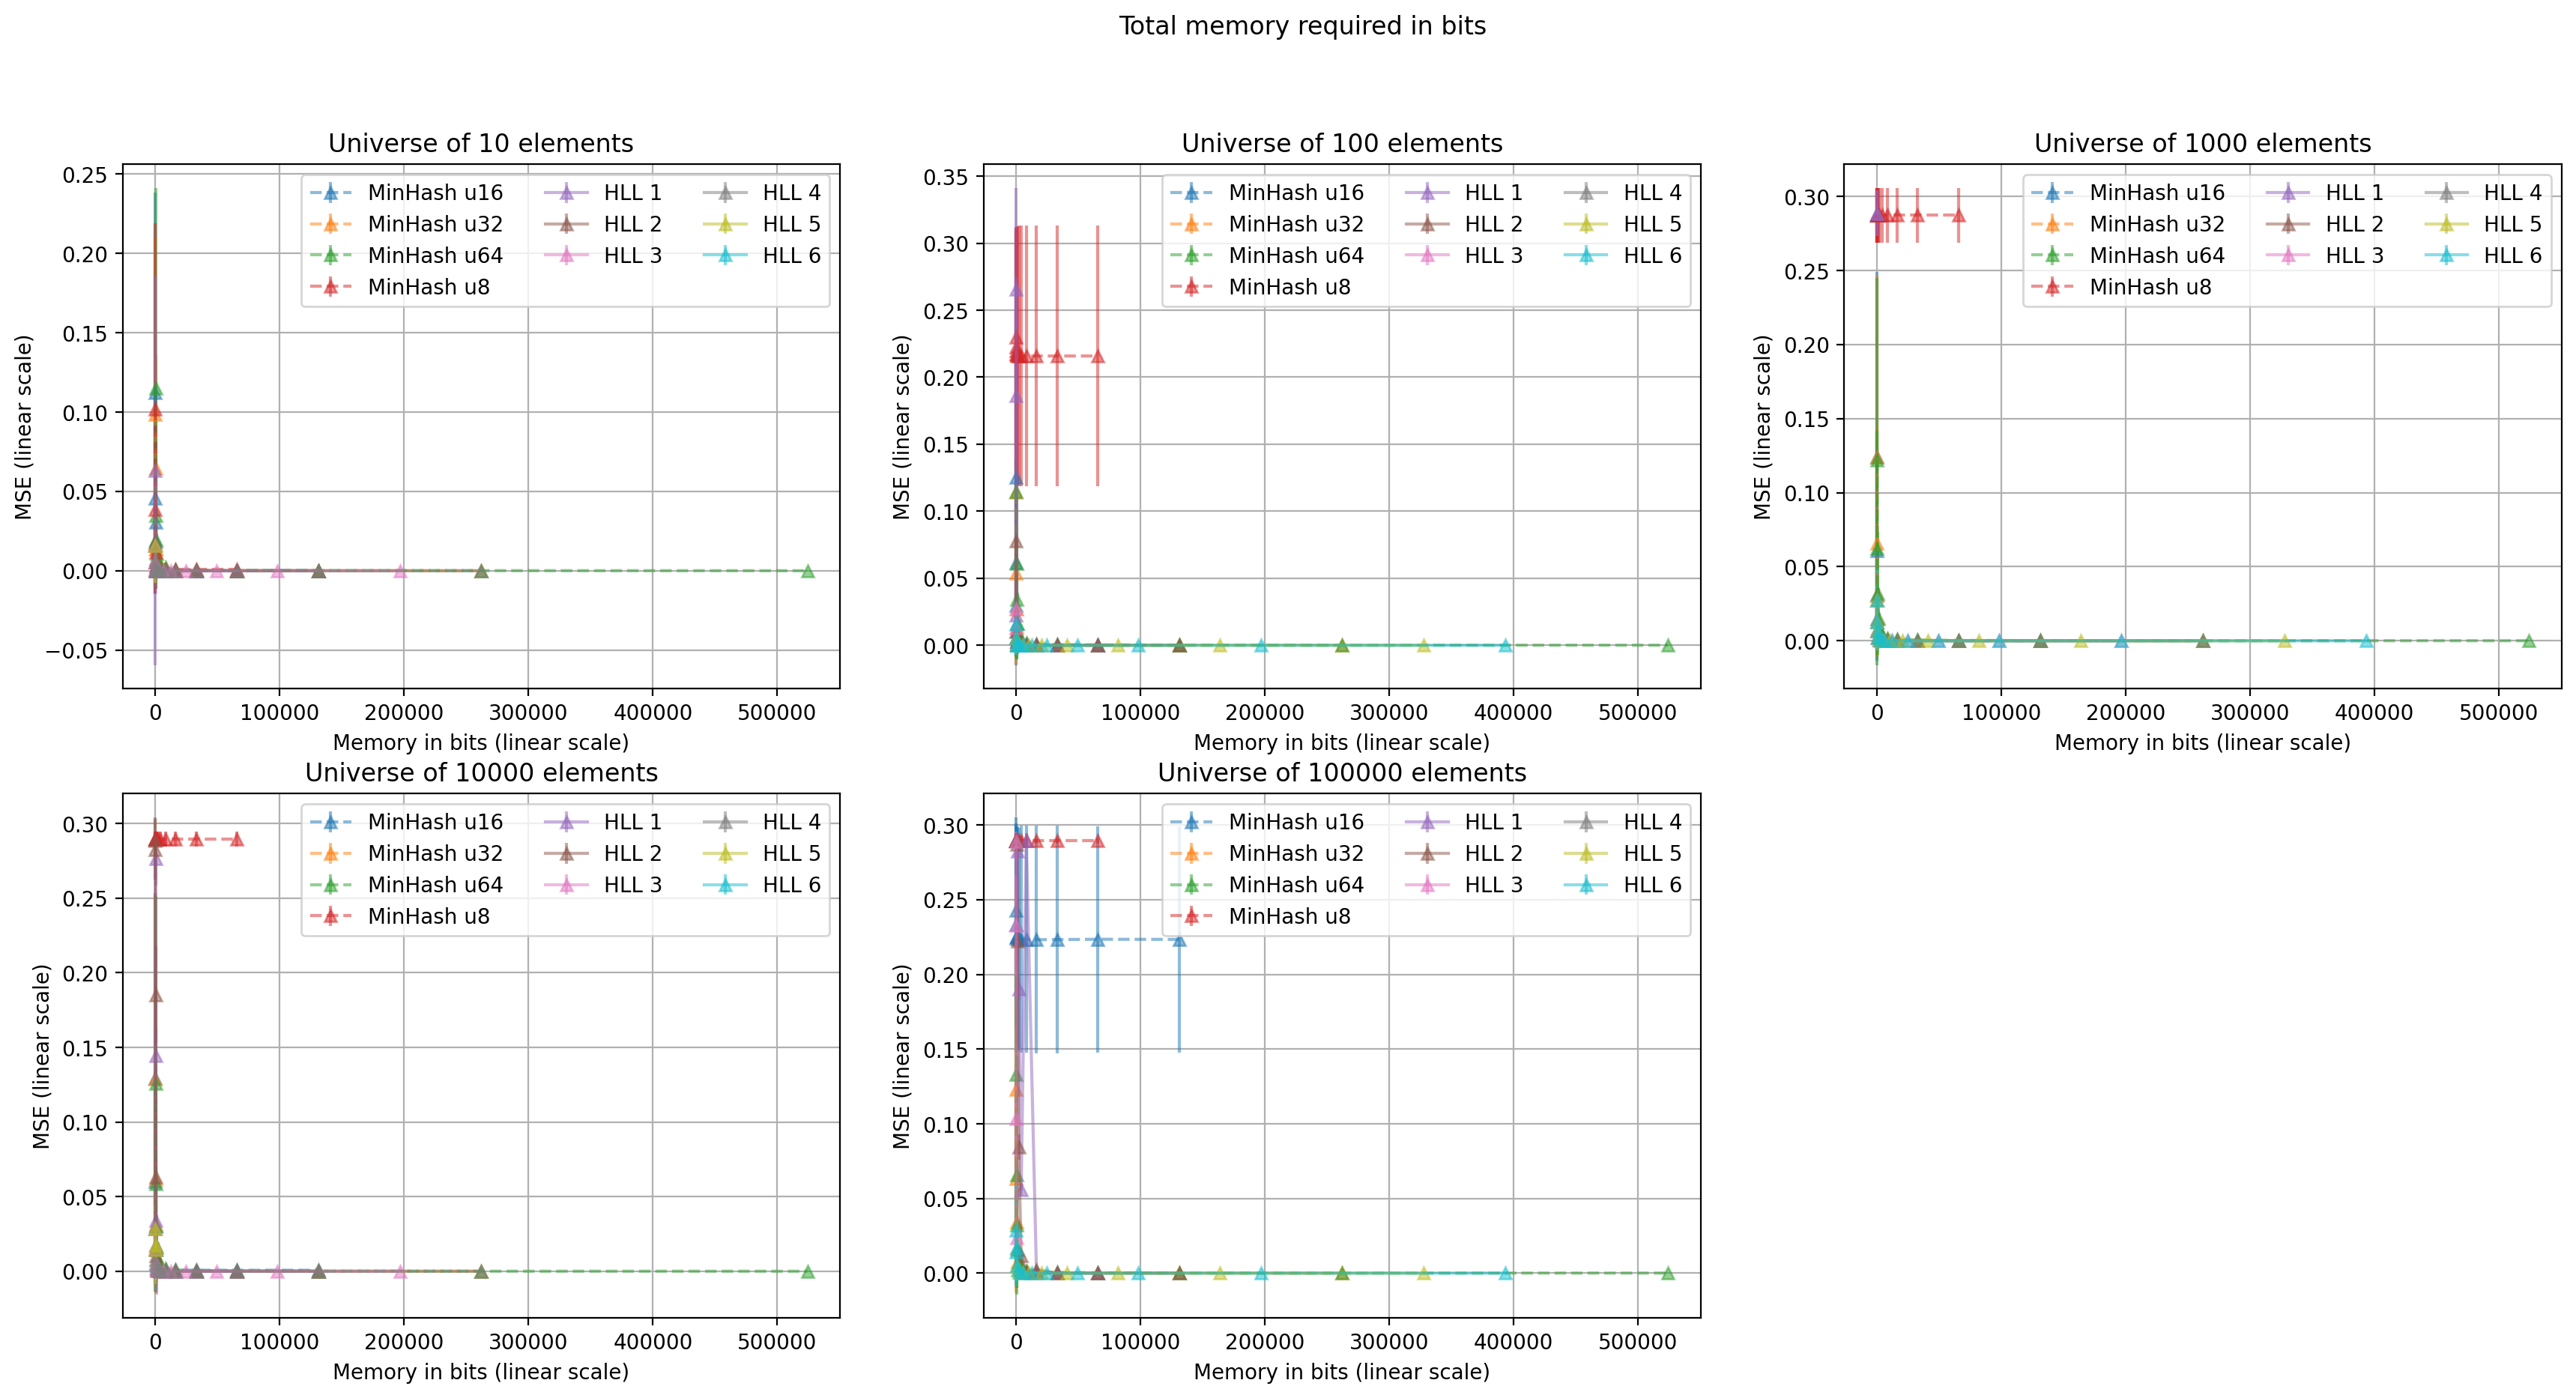

In [17]:
plots_per_row = 3

number_of_rows = math.ceil(len(hll.elements.unique()) / plots_per_row)

for scale in ("log", "linear"):
    fig, axes = plt.subplots(
        figsize=(plots_per_row*7, 5*number_of_rows),
        nrows=number_of_rows,
        ncols=plots_per_row,
        dpi=200
    )

    flat_axes = iter(axes.flatten())

    for elements, ax in zip(hll.elements.unique(), flat_axes):
        for word in minhash.word.unique():
            filtered = minhash[(minhash.word == word) & (minhash.elements == elements)].sort_values("memory")
            ax.errorbar(
                filtered.memory,
                filtered["mse"]["mean"],
                filtered["mse"]["std"],
                marker='^',
                ls='--',
                label=f"MinHash {word}",
                alpha=0.5
            )
        for bits in hll.bits.unique():
            filtered = hll[(hll.bits == bits)& (minhash.elements == elements)].sort_values("memory")
            ax.errorbar(
                filtered.memory,
                filtered["mse"]["mean"],
                filtered["mse"]["std"],
                marker='^',
                label=f"HLL {bits}",
                alpha=0.5
            )
        ax.set_title(f"Universe of {elements} elements")
        ax.set_xlabel(f"Memory in bits ({scale} scale)")
        ax.set_ylabel(f"MSE ({scale} scale)")
        ax.legend(ncol=3)
        ax.set_xscale(scale)
        ax.set_yscale(scale)
        ax.grid()

    for ax in flat_axes:
        ax.axis('off')
    
    fig.suptitle("Total memory required in bits")
    #fig.tight_layout()
    plt.show()

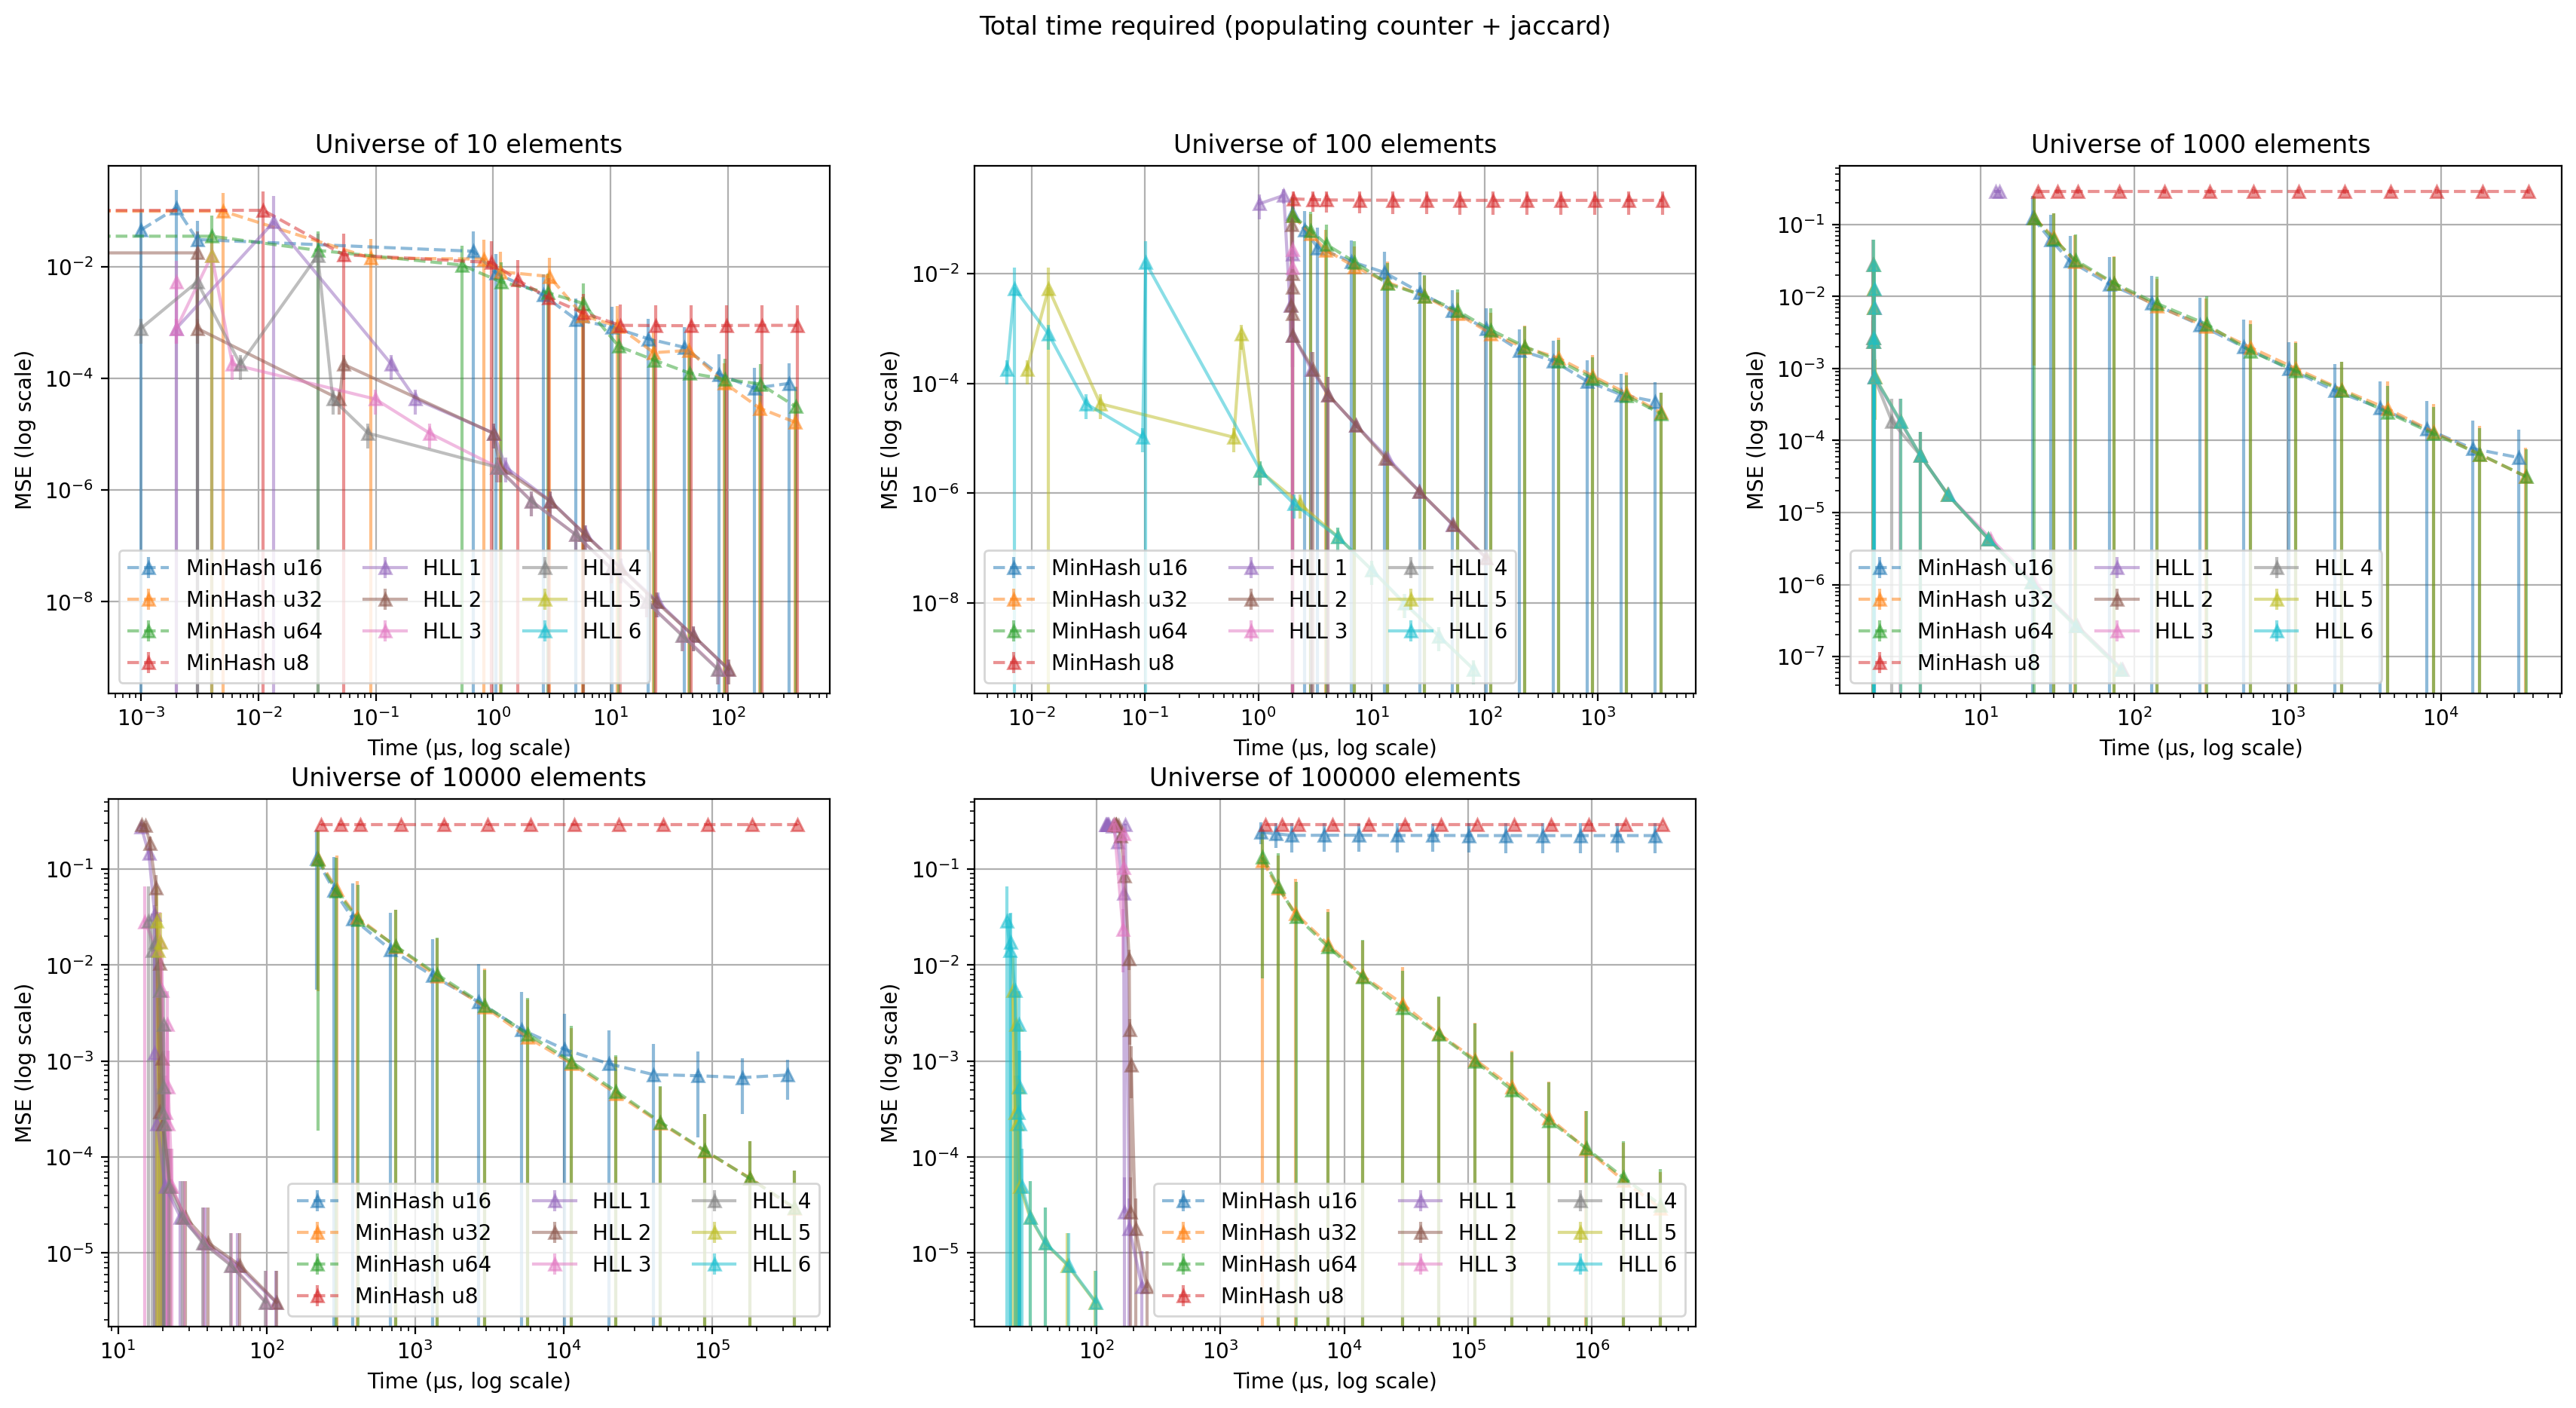

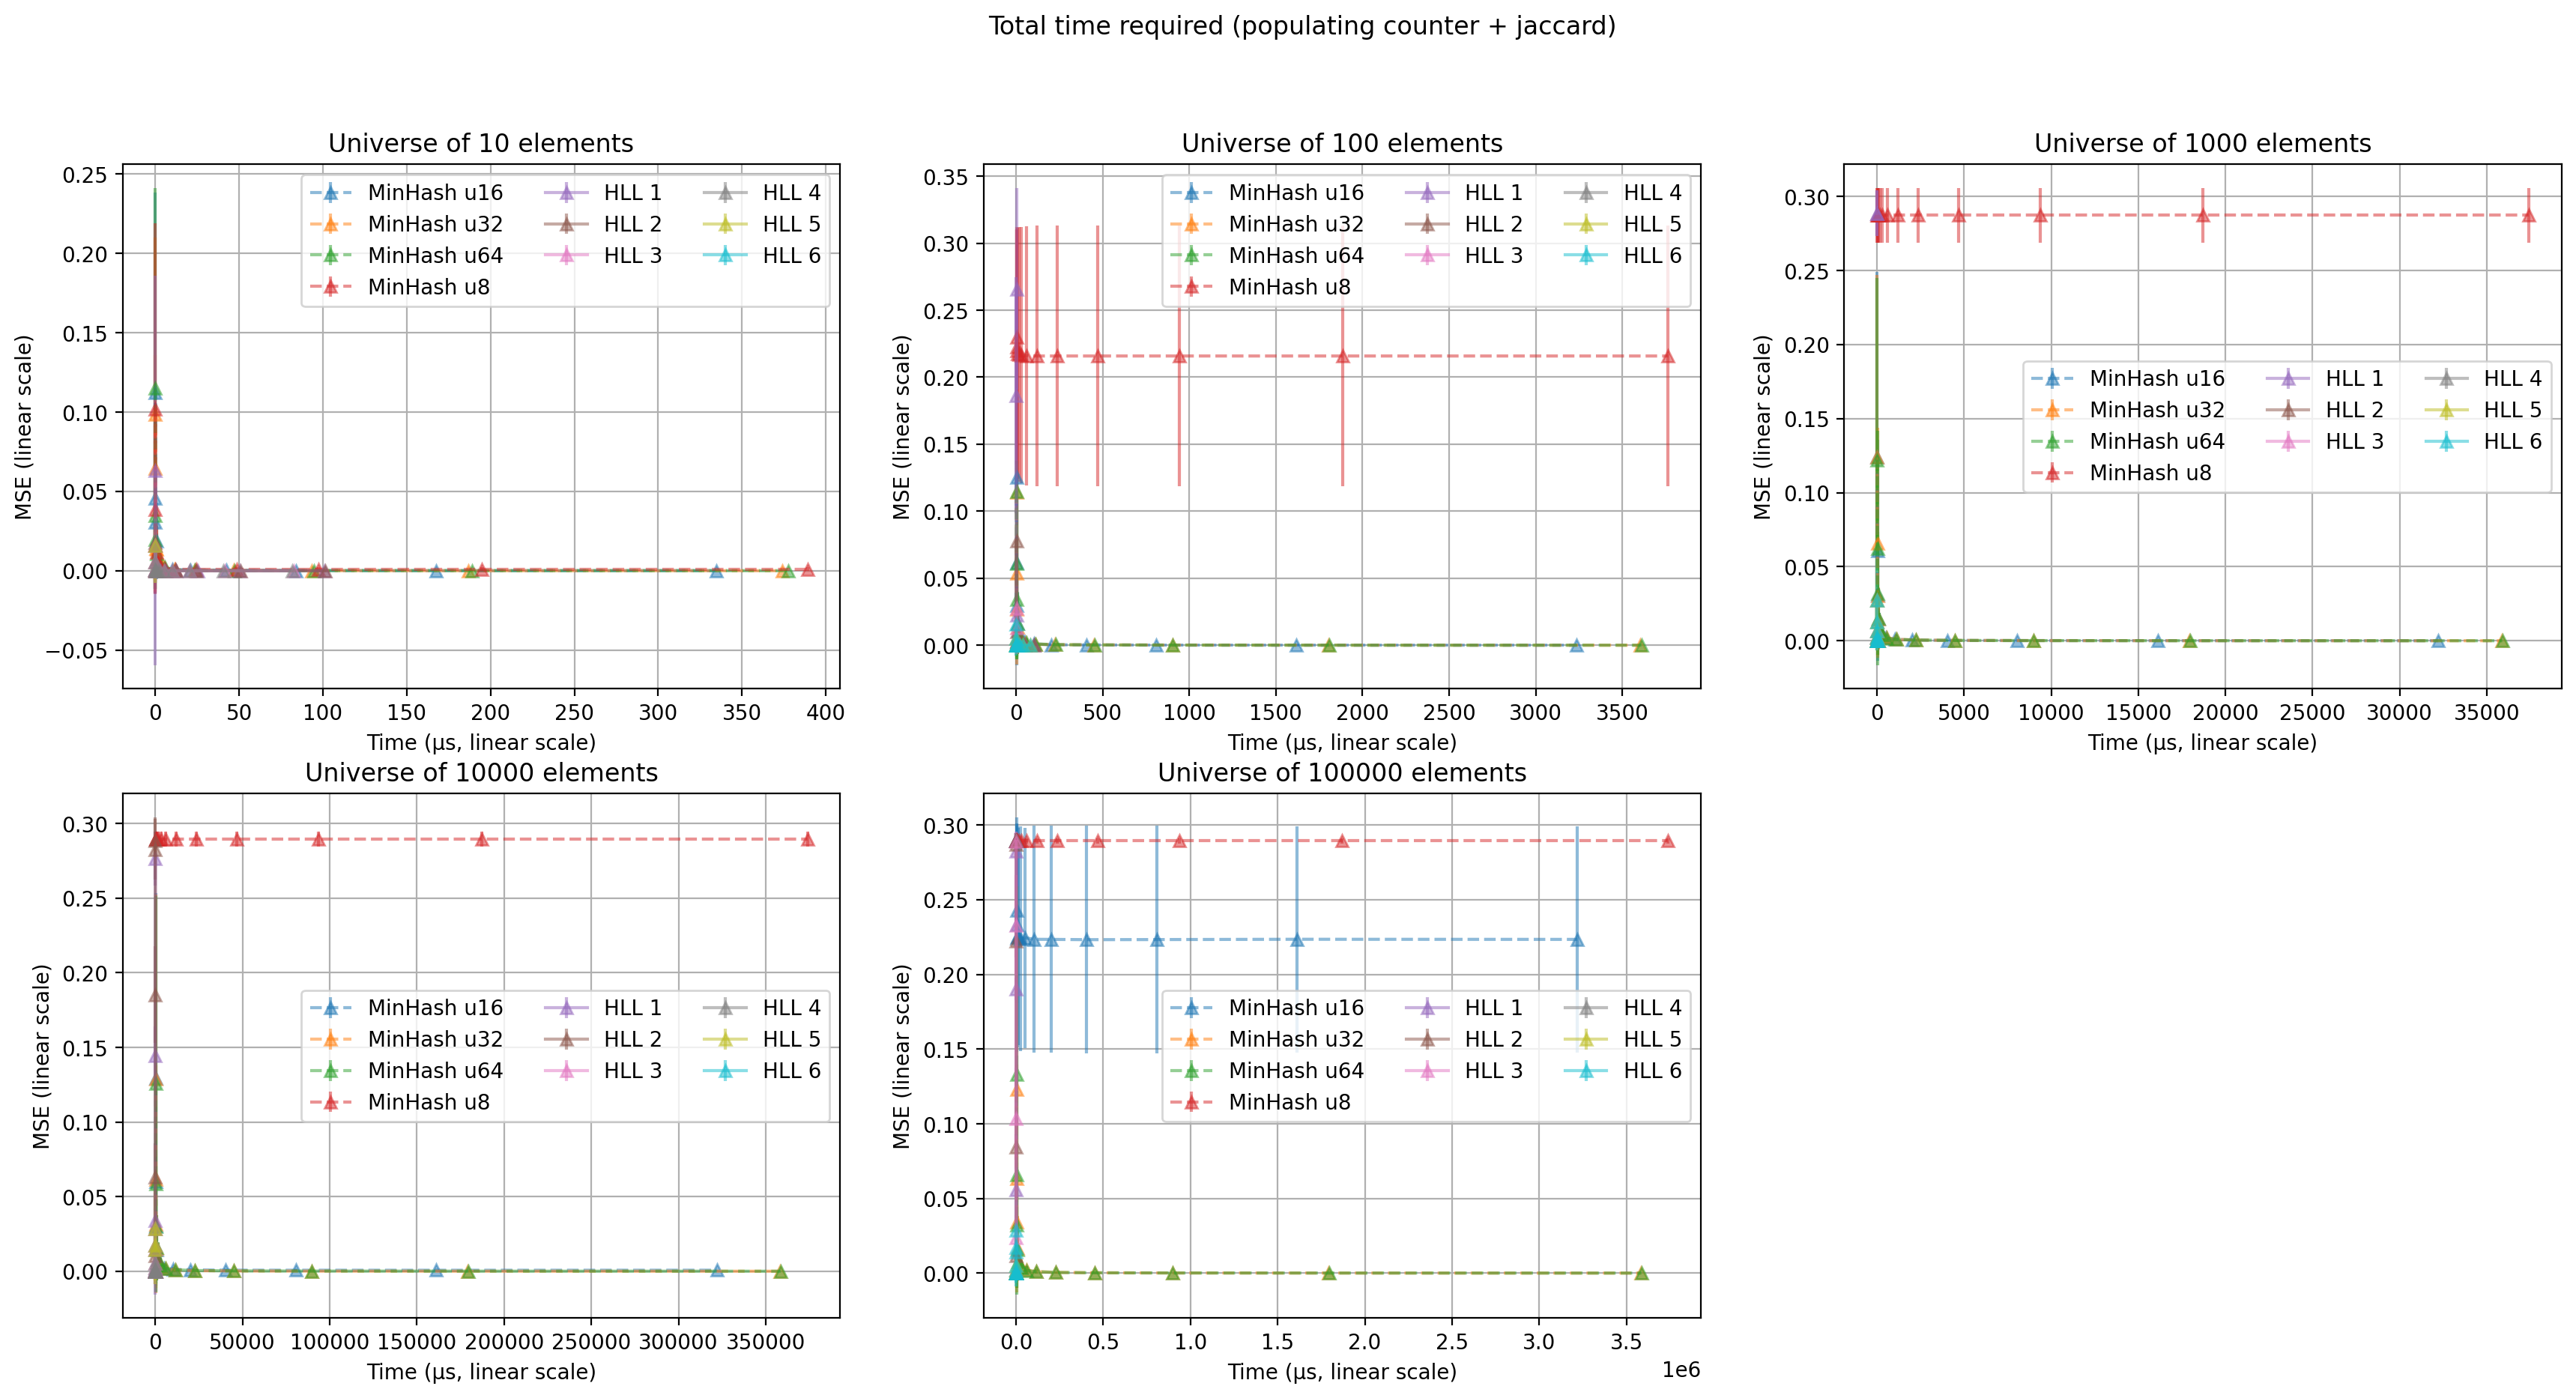

In [18]:
plots_per_row = 3

number_of_rows = math.ceil(len(hll.elements.unique()) / plots_per_row)

for scale in ("log", "linear"):
    fig, axes = plt.subplots(
        figsize=(plots_per_row*7, 5*number_of_rows),
        nrows=number_of_rows,
        ncols=plots_per_row,
        dpi=200
    )

    flat_axes = iter(axes.flatten())

    for elements, ax in zip(hll.elements.unique(), flat_axes):
        for word in minhash.word.unique():
            filtered = minhash[(minhash.word == word) & (minhash.elements == elements)].sort_values(("time", "mean"))
            ax.errorbar(
                filtered.time["mean"],
                filtered["mse"]["mean"],
                filtered["mse"]["std"],
                marker='^',
                ls='--',
                label=f"MinHash {word}",
                alpha=0.5
            )
        for bits in hll.bits.unique():
            filtered = hll[(hll.bits == bits)& (minhash.elements == elements)].sort_values(("time", "mean"))
            ax.errorbar(
                filtered.time["mean"],
                filtered["mse"]["mean"],
                filtered["mse"]["std"],
                marker='^',
                label=f"HLL {bits}",
                alpha=0.5
            )
        ax.set_title(f"Universe of {elements} elements")
        ax.set_xlabel(f"Time (μs, {scale} scale)")
        ax.set_ylabel(f"MSE ({scale} scale)")
        ax.legend(ncol=3)
        ax.set_xscale(scale)
        ax.set_yscale(scale)
        ax.grid()
    
    for ax in flat_axes:
        ax.axis('off')

    #fig.tight_layout()
    fig.suptitle("Total time required (populating counter + jaccard)")
    plt.show()